<H1>Comparison: Decision Tree vs. Random Forest</H1><br>
This is a comparison of a decision tree classifier and a random forest classifier in terms of computation time. I'll use the  UC Irvine <a href='https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection'SMS> sms spam dataset</a> and build a simple spam classifier to complete this task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import re, string
%matplotlib inline
from sklearn import tree
from sklearn import ensemble
from IPython.display import Image
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
import time

In [2]:
df = pd.read_csv('sms_raw.csv')

In [3]:
sms = df[['spam', 'message']].copy()
sms.spam = np.where((sms.spam=='spam'), True, False) #Set spam column to boolean, True if spam

In [4]:
sms.spam.value_counts() #See class imbalance. I'll address this later.

False    4825
True      747
Name: spam, dtype: int64

<H2>Features</H2><br>
Finding spam in this set is pretty easy. At a quick glance, I noticed that spam tends to be heavy in punctuation and numeric characters. It also has some specific words that occur frequently, and I found that spam tends to have a higher number of words as well.<br><br>
My features are built around these characteristics:<br>
-word count (integer)<br>
-having "spammy" words (True/False)<br>
-proportion of punctuation characters to all characters (float between 0 and 1)<br>
-proportion of numeric characters to all characters (float between 0 and 1)

In [5]:
sms['words'] = sms.message.str.lower().str.split()
sms['msg_length'] = sms.words.apply(len)
print(sms[sms.spam].msg_length.mean()) #Nice difference in mean msg length
print(sms[~sms.spam].msg_length.mean())

23.9116465863
14.3102590674


In [6]:
def strip_punc(words):
    """Takes a list of words and returns a list of words
    without punctuation
    """
    translator = str.maketrans('', '', string.punctuation)
    result = []
    for word in words:
        result.append(word.translate(translator))
    return result

sms.words = sms.words.apply(strip_punc)

In [7]:
def get_words(series):
    """Takes a series of lists of words and returns
    a single series of all words
    """
    words = []
    for item in series:
        words += item
    return pd.Series(words)

spam_words = get_words(sms[sms.spam].words)
ham_words = get_words(sms[~sms.spam].words)

In [8]:
spam_words = ['call', '2', 'free', 'txt', 'now']
sms['spammy_words'] = False
for row in sms.index: 
    for word in spam_words:
        if word in sms.loc[row].words:
            sms.set_value(row, 'spammy_words', True)   #Flag all those spammy messages

In [9]:
#measure ratio of characters that are punctuation.

def punc_count(in_string):
    """Takes a string and returns an
    integer number of punctuation characters
    found in that string.
    """
    count = 0
    punc = r'.*[{}]'.format(string.punctuation)
    for char in in_string:
        if bool(re.match(punc, char)):
            count += 1
    return count

sms['punctuation_ratio'] = sms.message.apply(punc_count)/sms.message.apply(len)


#measure ratio of number characters to text

def num_count(in_string):
    """Takes a string and returns an
    integer number of punctuation characters
    found in that string.
    """
    count = 0
    nums = r'.*[1234567890]'
    for char in in_string:
        if bool(re.match(nums, char)):
            count += 1
    return count

sms['num_ratio'] = sms.message.apply(num_count)/sms.message.apply(len)

<H1>Decision Tree</H1><br>
<H2>Imbalanced Tree</H2><br>
Before addresssing the class imbalance, I build and optimize a decision tree classifier:

In [10]:
#Set up modeling data
features = [
    'msg_length', 
    'spammy_words', 
    'punctuation_ratio', 
    'num_ratio'
]
X=sms[features]
Y=sms.spam

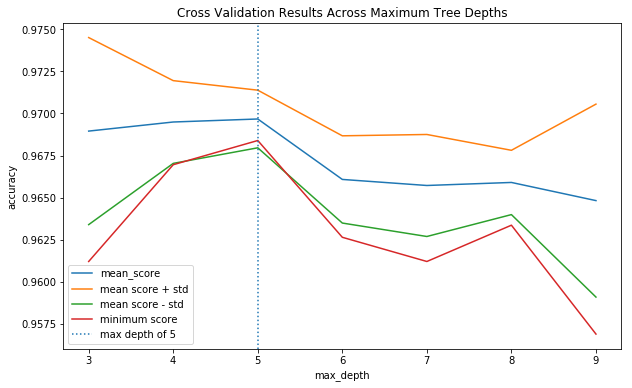

In [11]:
#This function helped me find the optimal decision tree maximum depth.

def test_dpths(X, Y, min_depth=3, m_depth=10, depth_step=1):
    """Tests multiple maximum decision tree depths.
    Returns dataframe with results.
    """
    dpth=[]
    mean_scores=[]
    min_scores=[]
    stds = []
    for dep in range(min_depth, m_depth, depth_step):
        tree_ = tree.DecisionTreeClassifier(max_depth=dep)
        scores = pd.Series(cross_val_score(tree_, X, Y, cv=4))
        mean_scores.append(scores.mean())
        min_scores.append(scores.min())
        stds.append(scores.std())
        dpth.append(dep)
    result = pd.DataFrame()
    result['depth'] = dpth
    result['mean_score'] = mean_scores
    result['min_score'] = min_scores
    result['std_'] = stds
    return result

res = test_dpths(X, Y)
res = res.set_index('depth')
plt.subplots(figsize=(10,6))
plt.plot(res.mean_score);
plt.plot(res.mean_score+res.std_, label='mean score + std');
plt.plot(res.mean_score-res.std_, label='mean score - std');
plt.plot(res.min_score, label='minimum score');
plt.axvline(x=5, linestyle='dotted', label='max depth of 5');
plt.title('Cross Validation Results Across Maximum Tree Depths');
plt.xlabel('max_depth');
plt.ylabel('accuracy');
plt.legend();
plt.show()

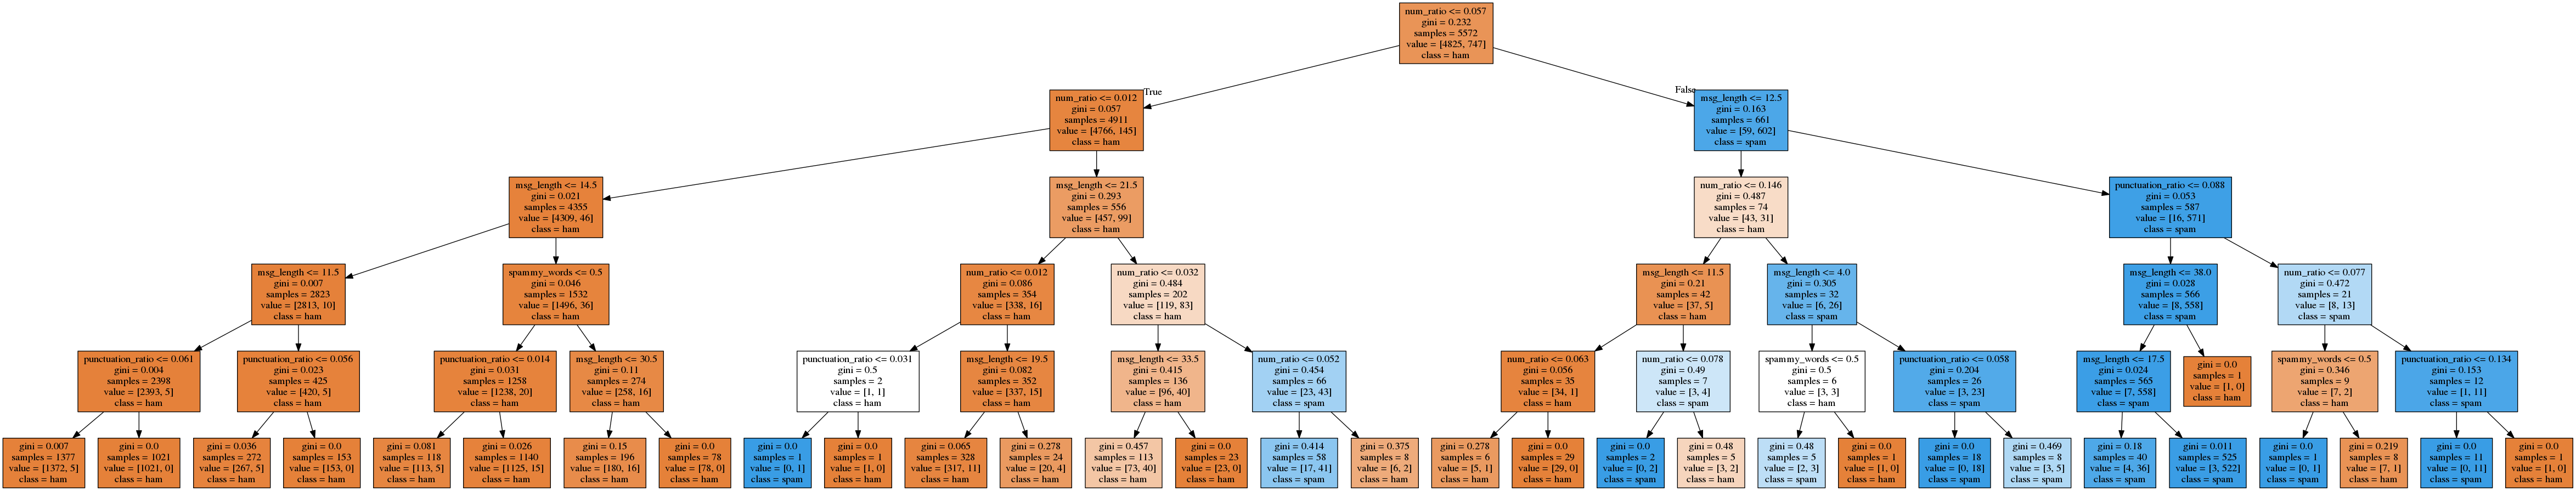

In [12]:
#Build and visualize decision tree
dec_tree = tree.DecisionTreeClassifier(
    max_depth=5
)

dec_tree.fit(X, Y)

dot_data = tree.export_graphviz(
    dec_tree, 
    out_file=None,
    feature_names=features,
    class_names=['ham', 'spam'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())                       #In the vis, blue is spam. Class bias is apparent but not terrible.

In [13]:
#This function helps quantify classifier performance, including runtime

def test_model(mod, X, Y, holdout=.5, cv=10):
    """Tests spam filter performance through various metrics and
    reports on runtime.
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=holdout)
    
    t1 = time.time()
    mod.fit(X_train, Y_train)
    print('training time: {}'.format(time.time() - t1))
    
    t1 = time.time()
    Y_ = mod.predict(X_test)
    print('prediction time: {}'.format(time.time() - t1))

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_).ravel()
    print('ham correctly identified: {}%'.format(tn/(fp+tn)))
    print('spam correctly identified: {}%'.format(tp/(fn+tp)))
    
    t1 = time.time()
    scores = pd.Series(cross_val_score(mod, X, Y, cv=cv))
    print('\ngetting cross validation scores...')
    print('mean score: {} +/- {}, min score: {}'.format(scores.mean(), scores.std(), scores.min()))
    print('cross validation test time: {} for {} tests.'.format(time.time()-t1, cv))
    
test_model(dec_tree, X, Y)

training time: 0.0060808658599853516
prediction time: 0.003138303756713867
ham correctly identified: 0.9867054424594931%
spam correctly identified: 0.8390501319261213%

getting cross validation scores...
mean score: 0.969304255443158 +/- 0.006107297692150054, min score: 0.9568345323741008
cross validation test time: 0.14411115646362305 for 10 tests.


<H3>Imbalanced Tree Performance Overview</H3><br>

The decision tree is pretty accurate and is more likely to admit spam than to block ham, which is how we'd want a spam filter to behave. This is probably due to the overall class imbalance. I'll try to address the imbalance and see if its performance changes.<br><br>
<H2>Balanced Decision Tree</H2><br>
I address the class imbalance in my decision tree.

In [14]:
#Sample ham to balance training data
sms_bal = pd.concat([sms[sms.spam], sms[~sms.spam].sample(747)]).sample(frac=1) #sample ham for balanced set

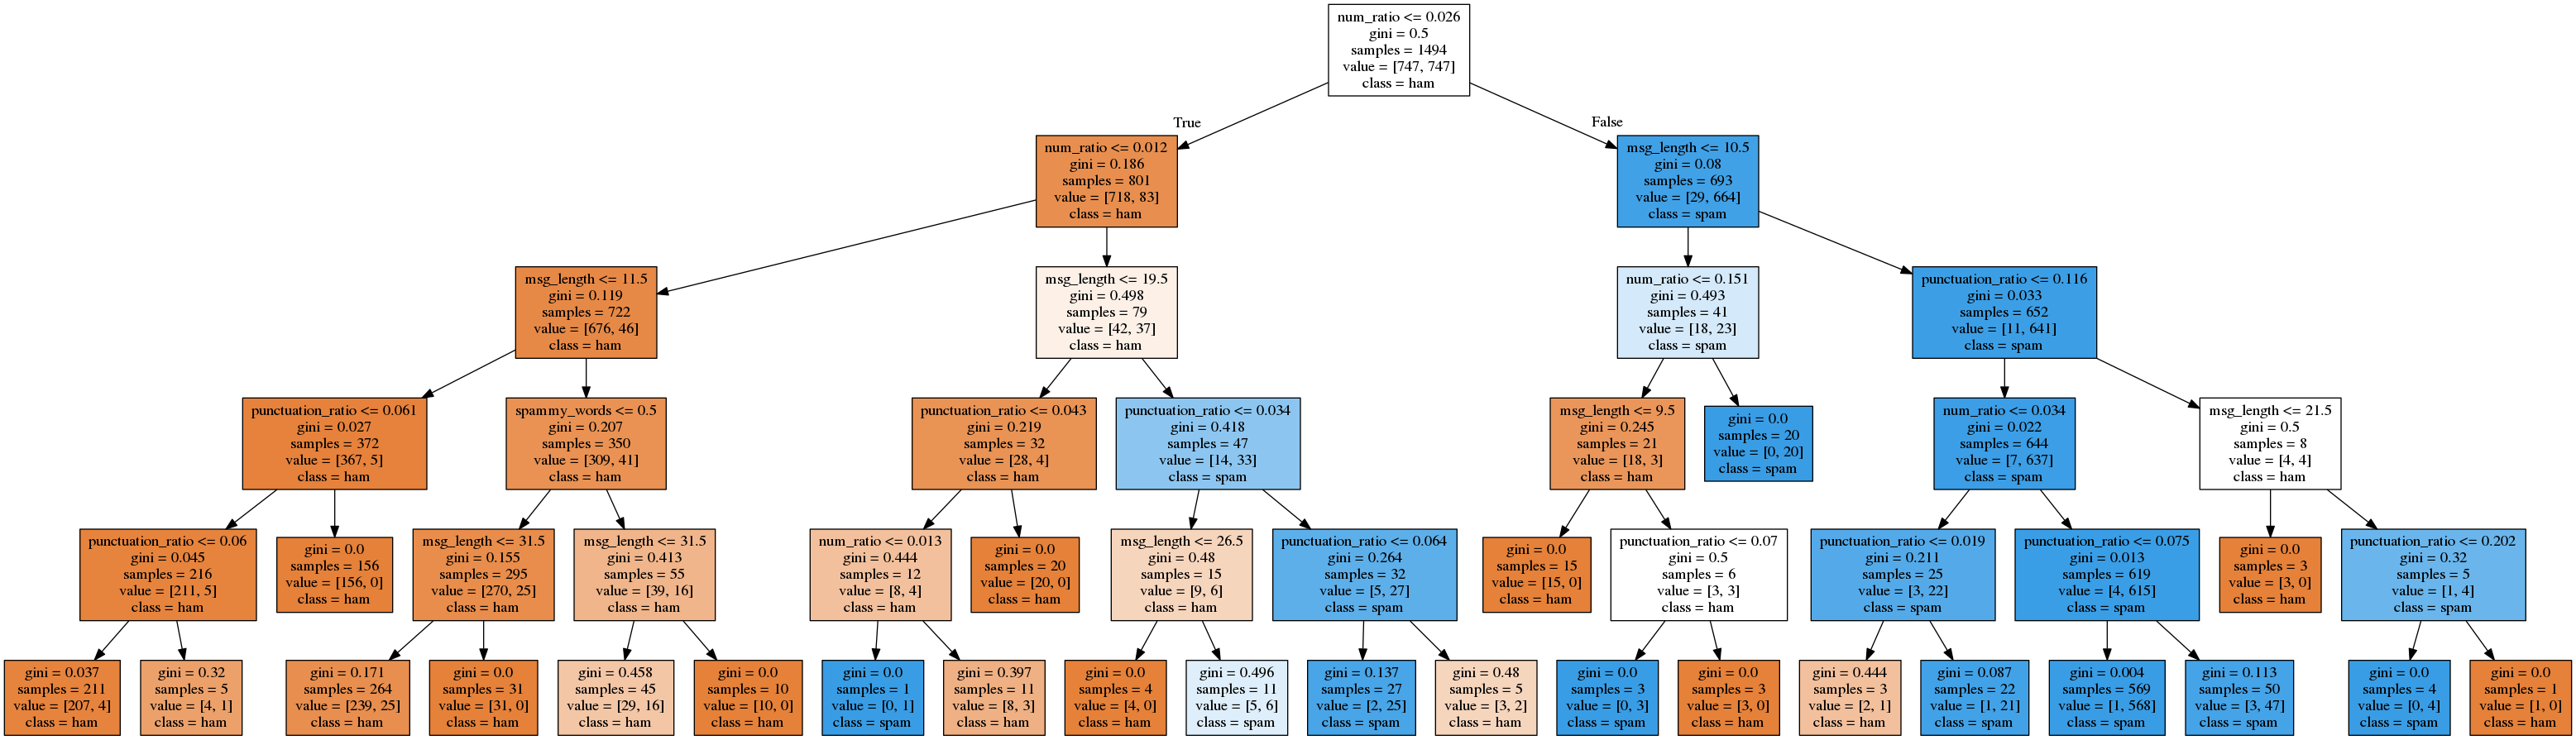

In [15]:
X = sms_bal[features]
Y = sms_bal.spam
dec_tree.fit(X, Y)                 #Fit to balanced training data

dot_data = tree.export_graphviz(
    dec_tree, 
    out_file=None,
    feature_names=features,
    class_names=['ham', 'spam'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())                                #Looks more balanced

In [16]:

X_test = sms[features]             #Test on full data set
Y_test = sms.spam
Y_ = dec_tree.predict(X_test)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_).ravel()
print('ham correctly identified: {}%'.format(tn/(fp+tn)))
print('spam correctly identified: {}%'.format(tp/(fn+tp)))
print('overall accuracy: {}%'.format((tp+tn)/(tp+tn+fp+fn)))

ham correctly identified: 0.965181347150259%
spam correctly identified: 0.9303882195448461%
overall accuracy: 0.9605168700646087%


<H3>Balanced Tree Performance Overview</H3><br>

Sure enough, when we balance the classes in training, the decision tree becomes more sensitive to spam. Its overall accuracy is very close to the imbalanced version. In practice, this model may be less useful because it has a higher tendency to block ham (3%, up from 1%), which could be annoying. <br><br>

<H1>Random Forest Classifier</H1><br>
I'll try to make a really simple random forest classifier. Here, "simplicity" will be quantified by model runtime.

In [17]:
forest = ensemble.RandomForestClassifier(
    max_depth=5                               #Try optimal depth from tree
)

X=sms[features]             #Set up training data
Y=sms.spam

test_model(forest, X, Y)

training time: 0.03487992286682129
prediction time: 0.0049593448638916016
ham correctly identified: 0.9929460580912863%
spam correctly identified: 0.8297872340425532%

getting cross validation scores...
mean score: 0.9709213471291653 +/- 0.006836896937467917, min score: 0.9568345323741008
cross validation test time: 0.47364258766174316 for 10 tests.


We see here that the training time is about fifteen times longer than in the decision tree, although prediction time is only slightly less than double that of the decision tree. The reward is a slight bump in overall performance, with both specificity and sensitivity to spam increasing by about a half of a percentage point.<br><br>
Let's see if we can reduce this model's runtime to that of the decision tree above. It will need to be a very, very small forest.


In [ ]:
small_forest = ensemble.RandomForestClassifier(
    max_depth=2,
    n_estimators=2
)

test_model(small_forest, X, Y)

training time: 0.007094860076904297
prediction time: 0.002214670181274414
ham correctly identified: 0.9950392724266226%
spam correctly identified: 0.782016348773842%

getting cross validation scores...
mean score: 0.9624868067554413 +/- 0.008246220745491181, min score: 0.9514388489208633
cross validation test time: 0.13761544227600098 for 10 tests.


We were able to reduce the complexity (as measured by runtime) of this model to be roughly equal to that of the above decision tree. In doing so, we lose a lot of performance. This indicates that a well-built decision tree can outperform a random forest model in terms of computation time, at least in some cases.<br><br>
<H2>How much better can the random forest do?</H2><br>
I crank up the parameters on our random forest classifier to see how much better it can do:

In [ ]:
deep_forest = ensemble.RandomForestClassifier(
    class_weight='balanced'
)

test_model(deep_forest, X, Y)

training time: 0.046436309814453125
prediction time: 0.005380392074584961
ham correctly identified: 0.9925155925155925%
spam correctly identified: 0.8267716535433071%


This forest, allowed to reach any depth, takes a similar amount of time to train and predict. The automatic class balancing feature helps increase sensitivity to spam, but not by much.<br><br>
Finally, let's see how a really big forest does:

In [ ]:
big_forest = ensemble.RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100
)

test_model(big_forest, X, Y)

As expected, the higher number of trees increases runtime by almost an order of magnitude. We see very little improvement in performance.
<H3>Random Forest Performance Overview</H3><br>
Random forest models are a popular benchmark for predictive ability. They do well at the cost of requiring many computations, and rely on many redudant calculations to make predictions. We can see that major increases in complexity yield diminishing returns on performance improvement.<br><br>
<H1>Conclusion</H1><br>
Random forest models are useful and powerful, but this excercise shows that a well-built decision tree is more computationally efficient than and can compete with random forest models.